In [16]:
# imports for this notebook
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import theano as T
import theano.tensor as tt
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

import warnings
from scipy import VisibleDeprecationWarning
warnings.filterwarnings("ignore", category=VisibleDeprecationWarning) 

import copy


import pymc3 as pm
import scipy as sp
import scipy.stats as stats

import cv2
import cw_utils

In [17]:
data_csvs = {}
path = './../data/test_data/'
names = [
    "test1-2017-11-03T09-31.csv",
    "test2-2017-11-08T09-19.csv",
    "test3-2017-11-09T09-23.csv",
    "test4-2017-11-10T09-24.csv",
    "test5-2017-11-16T11-41.csv"
]
data_csvs['df_1'] = pd.read_csv(path+ names[0]).iloc[6:]
data_csvs['df_2'] = pd.read_csv(path+ names[1]).iloc[6:]
data_csvs['df_3'] = pd.read_csv(path+ names[2]).iloc[6:]
data_csvs['df_4'] = pd.read_csv(path+ names[3]).iloc[6:]
data_csvs['df_5'] = pd.read_csv(path+ names[4]).iloc[6:]

for k,v in data_csvs.items():
    
    data_csvs[k].columns = data_csvs[k].columns.str.strip()
    data_csvs[k] = data_csvs[k][['Desert_Water', 'Jungle_Water', 'Wetlands_Water', 'Plains_Water']]
    data_csvs[k]['Other_Water'] = 2.5-data_csvs[k].sum(axis=1)
    data_csvs[k] = data_csvs[k] / 2.5
    data_csvs[k] = data_csvs[k][['Other_Water', 'Desert_Water', 'Jungle_Water', 'Wetlands_Water', 'Plains_Water']]

data_csvs['df_2'].head(2)

/Users/nickhoernle/anaconda2/envs/ipython3/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Other_Water,Desert_Water,Jungle_Water,Wetlands_Water,Plains_Water
6,1.0,0.0,0.0,0.0,0.0
7,1.0,0.0,0.0,0.0,0.0


### Convert the .mov files for easier viewing

In [18]:
# don't run this if not necessary
# for f_name in names:
    
#     print(f_name)
#     mov_name = f_name.replace('.csv', '.mov')
#     cw_utils.get_mini_view_video(path + mov_name, path + f_name)

# Run State-Estimation to Find Params

### Test 1

In [19]:
results = {}

In [20]:
mu0 = np.ones(5)/5
Sig0 = np.eye(5)*1
Phi = np.eye(5)
Q = np.eye(5)*1e-3
R = np.eye(5)*1e-8
N = 5

params = {"mu0": mu0, 
           "Sig0": Sig0, 
           "Phi": Phi, 
           "Q": Q, 
           "R": R,
           "A": np.eye(N)}

In [21]:
df_name = 'df_1'

if df_name in results:
    em_res = results[df_name]
else:
    em_res = cw_utils.learn_breakpoint(data_csvs[df_name].values, num_breaks=6, starting_params=params, percentage=90)
    results[df_name] = em_res

[  0  64 128 192 256 320 387]
[  0  84 133 226 274 318 387]
3
[  0  88 131 266 318 387]
[  0  83 132 273 318 387]
[  0  85 135 283 318 387]
[  0  88 138 278 314 387]
[  0  82 132 273 309 387]
3
[  0  83 136 308 387]
[  0  85 134 304 387]
[  0  88 140 294 387]
[  0  83 138 291 387]
Converged


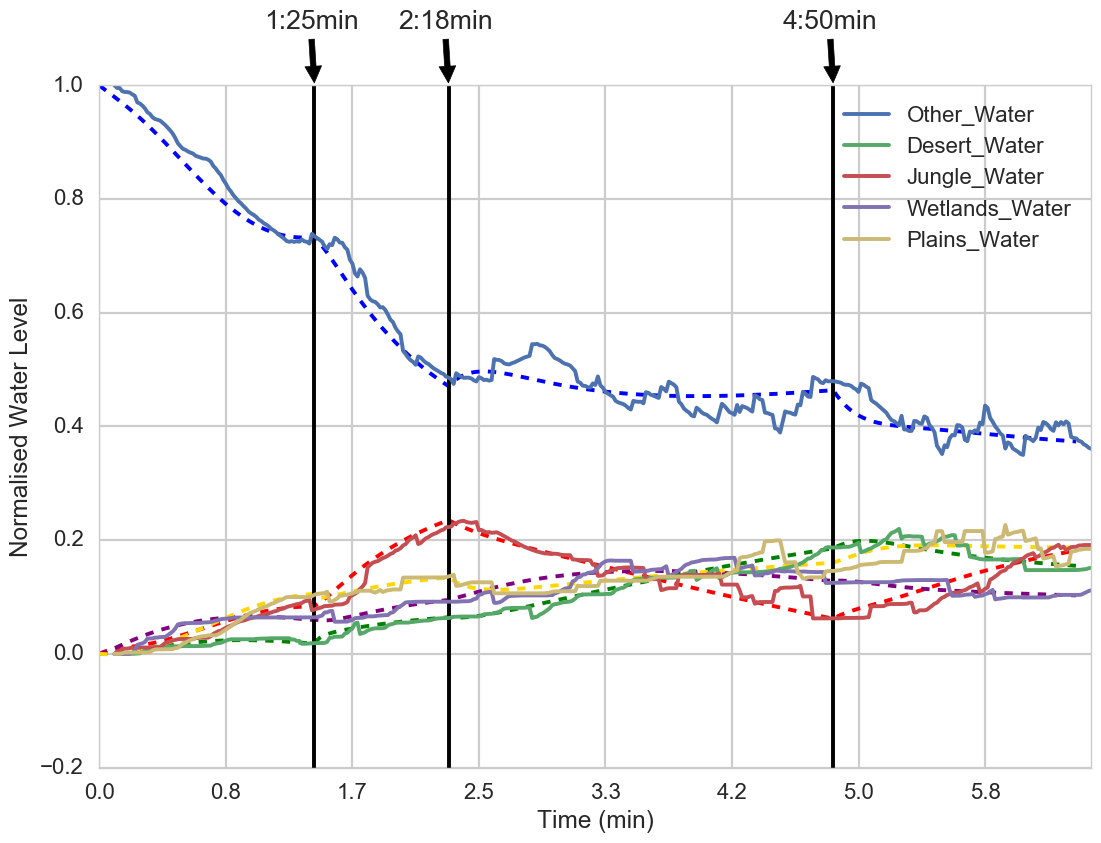

In [22]:
fig, ax = plt.subplots(1,1)
ax = cw_utils.plot_data_and_boundaries(df=data_csvs[df_name], em_results=em_res, ax=ax)
plt.show()

test1-2017-11-03T09-31.csv
Split 1:25 min
Logs leading into Split


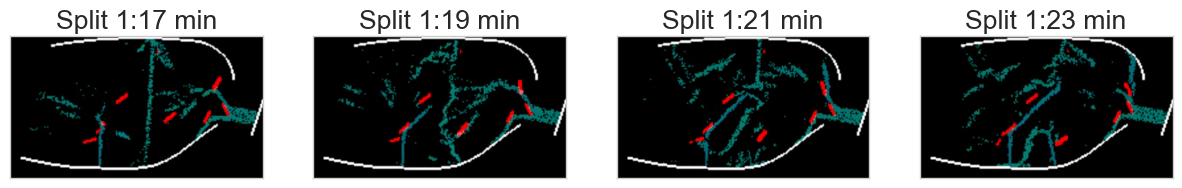

Logs after split


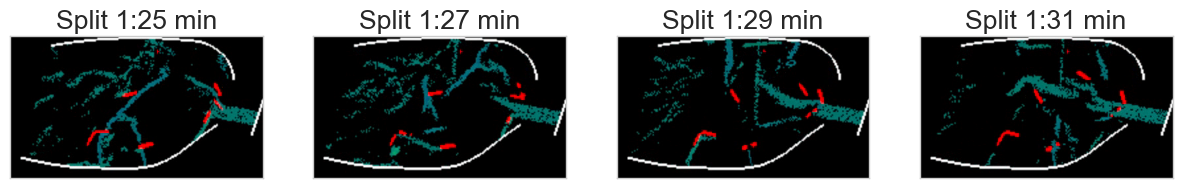

--------------------------------------------------------
--------------------------------------------------------

Split 2:18 min
Logs leading into Split


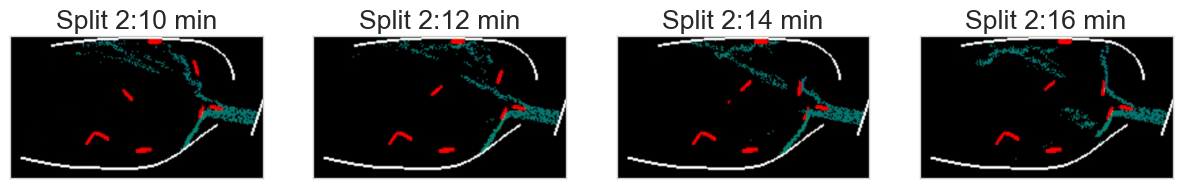

Logs after split


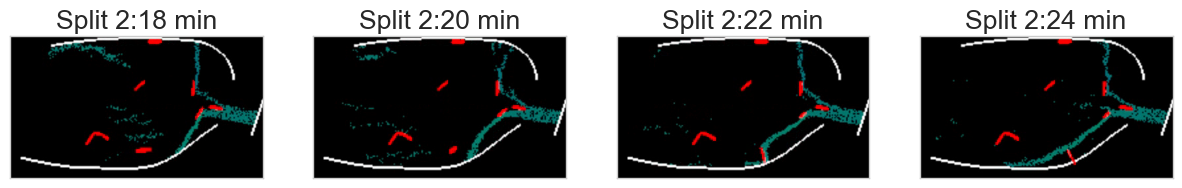

--------------------------------------------------------
--------------------------------------------------------

Split 4:50 min
Logs leading into Split


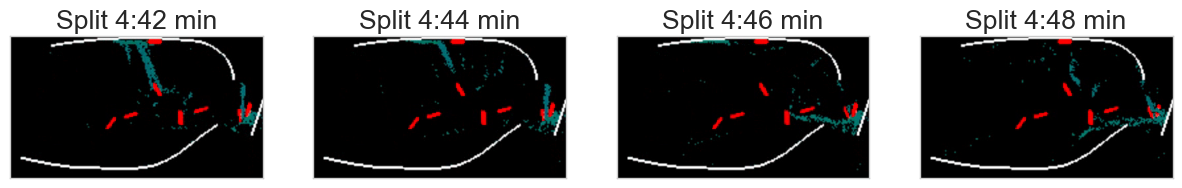

Logs after split


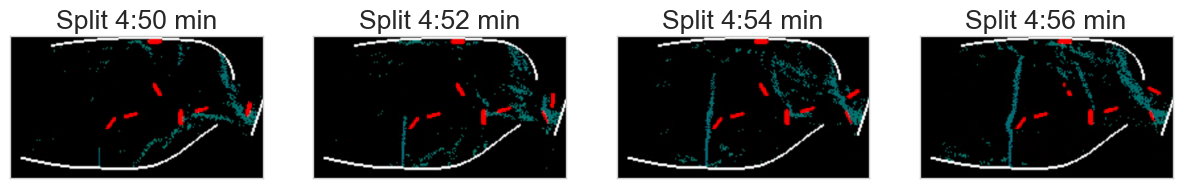

--------------------------------------------------------
--------------------------------------------------------



In [23]:
# for each split in found splits
video_name = names[int(df_name.split('_')[1])-1]
print(video_name)
video_name = video_name.replace('.csv', '.mov')
for time_split in results[df_name]['breaks']:
    
    if time_split not in [0, len(data_csvs[df_name].values)]:
        
        min_ = time_split // 60
        sec_ = time_split - (min_ * 60)

        print("Split %i:%02d min" % (min_, sec_))
        print("Logs leading into Split")
        fig, axes = plt.subplots(1,4, figsize=(15,4))
        for i, ax in enumerate(axes):
            
            ts = time_split - (8-2*i)
            min_ = ts // 60
            sec_ = ts - (min_ * 60)
        
            ax.set_title("Split %i:%02d min" % (min_, sec_))
            
            cap = cv2.VideoCapture(path + video_name)
            cap.set(1,ts)
            ret, frame = cap.read()
            
            ax.set_aspect('equal')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    
            ax.imshow(frame[864:1080,0:384])
        plt.show()
        
        print("Logs after split")
        fig, axes = plt.subplots(1,4, figsize=(15,4))
        for i, ax in enumerate(axes):
            
            ts = time_split + 2*(i)
            min_ = ts // 60
            sec_ = ts - (min_ * 60)
        
            ax.set_title("Split %i:%02d min" % (min_, sec_))
            
            cap = cv2.VideoCapture(path + video_name)
            cap.set(1,ts)
            ret, frame = cap.read()
            
            ax.set_aspect('equal')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    
            ax.imshow(frame[864:1080,0:384])
        plt.show()
        
        print('--------------------------------------------------------')
        print('--------------------------------------------------------')
        print()

<hr />
### Test 2

In [24]:
df_name = 'df_2'

if df_name in results:
    em_res = results[df_name]
else:
    em_res = cw_utils.learn_breakpoint(data_csvs[df_name].values, num_breaks=6, starting_params=params, percentage=88)
    results[df_name] = em_res

[  0  66 132 198 264 330 396]
SVD Converge Caught 5
[  0  79 158 237 316 396]
SVD Converge Caught 4
[  0  99 198 297 396]
SVD Converge Caught 3
[  0 132 264 396]
[  0 148 290 396]
[  0 153 304 396]
[  0 154 298 396]
[  0 152 302 396]
[  0 193 299 396]
[  0 204 311 396]
Converged


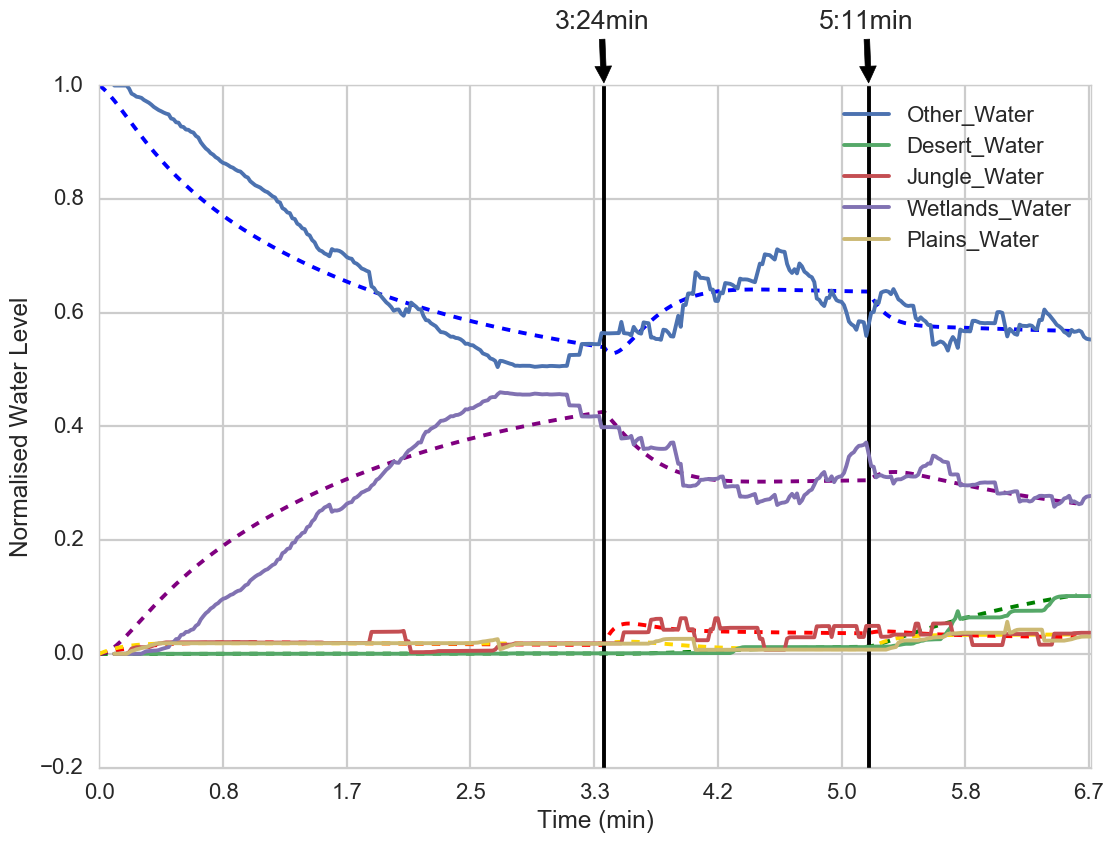

In [25]:
fig, ax = plt.subplots(1,1)
ax = cw_utils.plot_data_and_boundaries(df=data_csvs[df_name], em_results=em_res, ax=ax)
plt.show()

test2-2017-11-08T09-19.csv
Split 3:24 min
Logs leading into Split


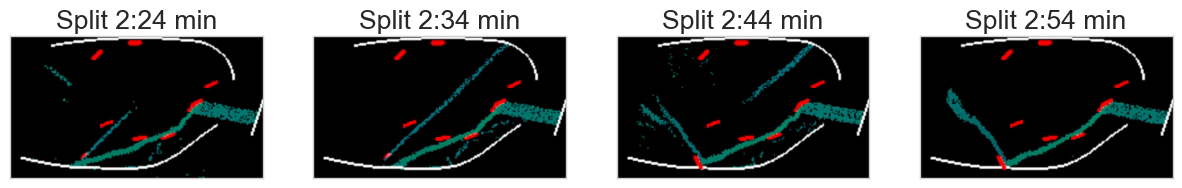

Logs after split


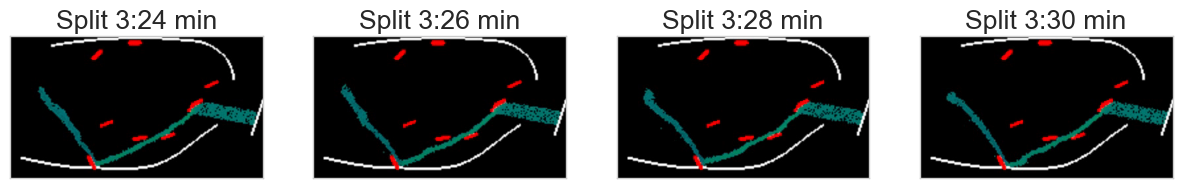

--------------------------------------------------------
--------------------------------------------------------

Split 5:11 min
Logs leading into Split


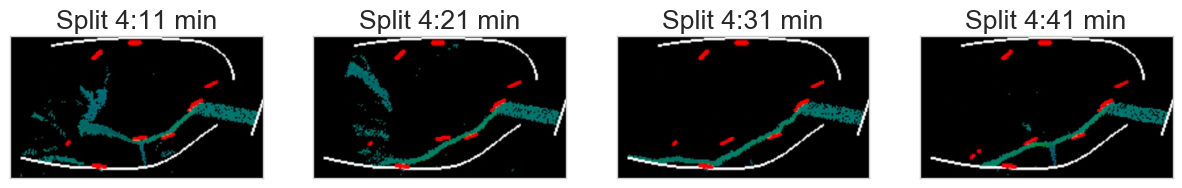

Logs after split


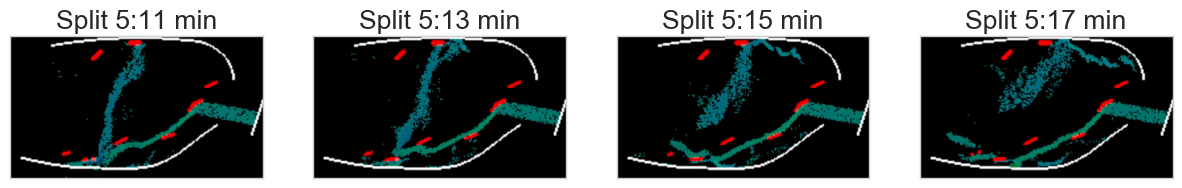

--------------------------------------------------------
--------------------------------------------------------



In [26]:
# for each split in found splits
video_name = names[int(df_name.split('_')[1])-1]
print(video_name)
video_name = video_name.replace('.csv', '.mov')
for time_split in results[df_name]['breaks']:
    
    if time_split not in [0, len(data_csvs[df_name].values)]:
        
        min_ = time_split // 60
        sec_ = time_split - (min_ * 60)

        print("Split %i:%02d min" % (min_, sec_))
        print("Logs leading into Split")
        fig, axes = plt.subplots(1,4, figsize=(15,4))
        for i, ax in enumerate(axes):
            
            ts = time_split - (60-10*i)
            min_ = ts // 60
            sec_ = ts - (min_ * 60)
        
            ax.set_title("Split %i:%02d min" % (min_, sec_))
            
            cap = cv2.VideoCapture(path + video_name)
            cap.set(1,ts)
            ret, frame = cap.read()
            
            ax.set_aspect('equal')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    
            ax.imshow(frame[864:1080,0:384])
        plt.show()
        
        print("Logs after split")
        fig, axes = plt.subplots(1,4, figsize=(15,4))
        for i, ax in enumerate(axes):
            
            ts = time_split + 2*(i)
            min_ = ts // 60
            sec_ = ts - (min_ * 60)
        
            ax.set_title("Split %i:%02d min" % (min_, sec_))
            
            cap = cv2.VideoCapture(path + video_name)
            cap.set(1,ts)
            ret, frame = cap.read()
            
            ax.set_aspect('equal')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    
            ax.imshow(frame[864:1080,0:384])
        plt.show()
        
        print('--------------------------------------------------------')
        print('--------------------------------------------------------')
        print()

<hr />
### Test 3

In [27]:
df_name = 'df_3'
flag = False
if flag and df_name in results:
    em_res = results[df_name]
else:
    em_res = cw_utils.learn_breakpoint(data_csvs[df_name].values, num_breaks=6, starting_params=params, percentage=88)
    results[df_name] = em_res

[  0  66 132 198 264 330 396]
SVD Converge Caught 5
[  0  79 158 237 316 396]
SVD Converge Caught 4
[  0  99 198 297 396]
[  0  92 220 292 396]
SVD Converge Caught 3
[  0 132 264 396]
[  0 194 276 396]
SVD Converge Caught 2
[  0 198 396]
[  0 220 396]
[  0 229 396]
[  0 231 396]
[  0 235 396]
[  0 246 396]
[  0 267 396]
[  0 270 396]
Converged


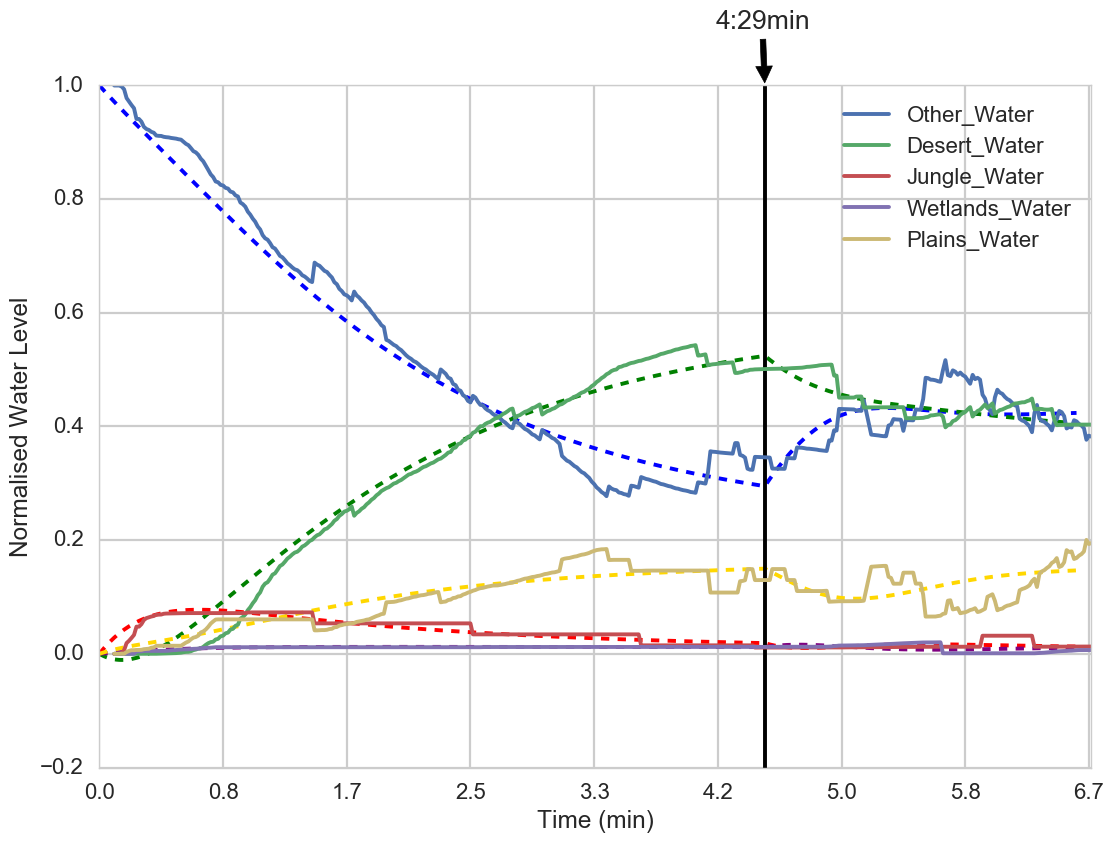

In [28]:
fig, ax = plt.subplots(1,1)
ax = cw_utils.plot_data_and_boundaries(df=data_csvs[df_name], em_results=em_res, ax=ax)
plt.show()

Split 4:29 min
Logs leading into Split


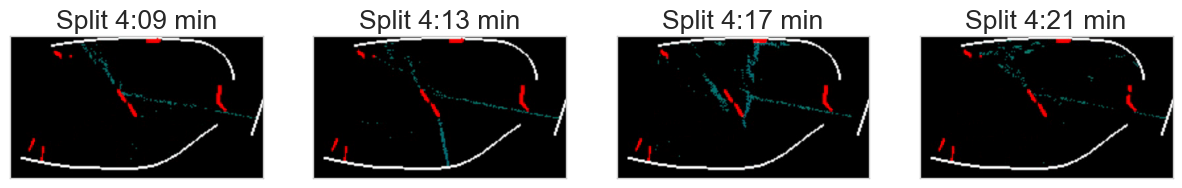

Logs after split


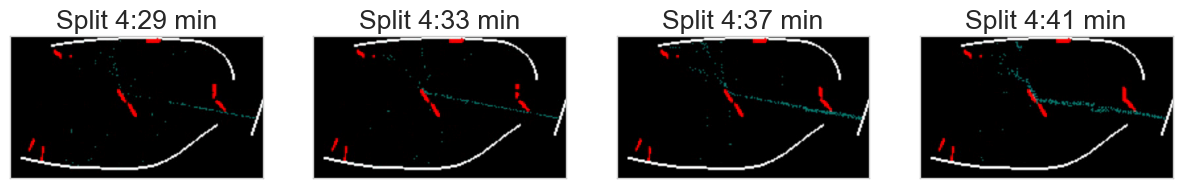

--------------------------------------------------------
--------------------------------------------------------



In [29]:
# for each split in found splits
video_name = names[int(df_name.split('_')[1])-1]
video_name = video_name.replace('.csv', '.mov')
for time_split in results[df_name]['breaks']:
    
    if time_split not in [0, len(data_csvs[df_name].values)]:
        
        min_ = time_split // 60
        sec_ = time_split - (min_ * 60)

        print("Split %i:%02d min" % (min_, sec_))
        print("Logs leading into Split")
        fig, axes = plt.subplots(1,4, figsize=(15,4))
        for i, ax in enumerate(axes):
            
            ts = time_split - (20-4*i)
            min_ = ts // 60
            sec_ = ts - (min_ * 60)
        
            ax.set_title("Split %i:%02d min" % (min_, sec_))
            
            cap = cv2.VideoCapture(path + video_name)
            cap.set(1,ts)
            ret, frame = cap.read()
            
            ax.set_aspect('equal')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    
            ax.imshow(frame[864:1080,0:384])
        plt.show()
        
        print("Logs after split")
        fig, axes = plt.subplots(1,4, figsize=(15,4))
        for i, ax in enumerate(axes):
            
            ts = time_split + 4*(i)
            min_ = ts // 60
            sec_ = ts - (min_ * 60)
        
            ax.set_title("Split %i:%02d min" % (min_, sec_))
            
            cap = cv2.VideoCapture(path + video_name)
            cap.set(1,ts)
            ret, frame = cap.read()
            
            ax.set_aspect('equal')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    
            ax.imshow(frame[864:1080,0:384])
        plt.show()
        
        print('--------------------------------------------------------')
        print('--------------------------------------------------------')
        print()

<hr />
### Test 4

In [30]:
df_name = 'df_4'

if df_name in results:
    em_res = results[df_name]
else:
    em_res = cw_utils.learn_breakpoint(data_csvs[df_name].values, num_breaks=6, starting_params=params, percentage=95)
    results[df_name] = em_res

[  0  65 130 195 260 325 391]
2
[  0 201 197 262 349 391]
SVD Converge Caught 4
[  0  97 194 291 391]
2
[  0 115 285 391]
[  0 280 335 391]
[  0 275 350 391]
[  0 272 349 391]
Converged


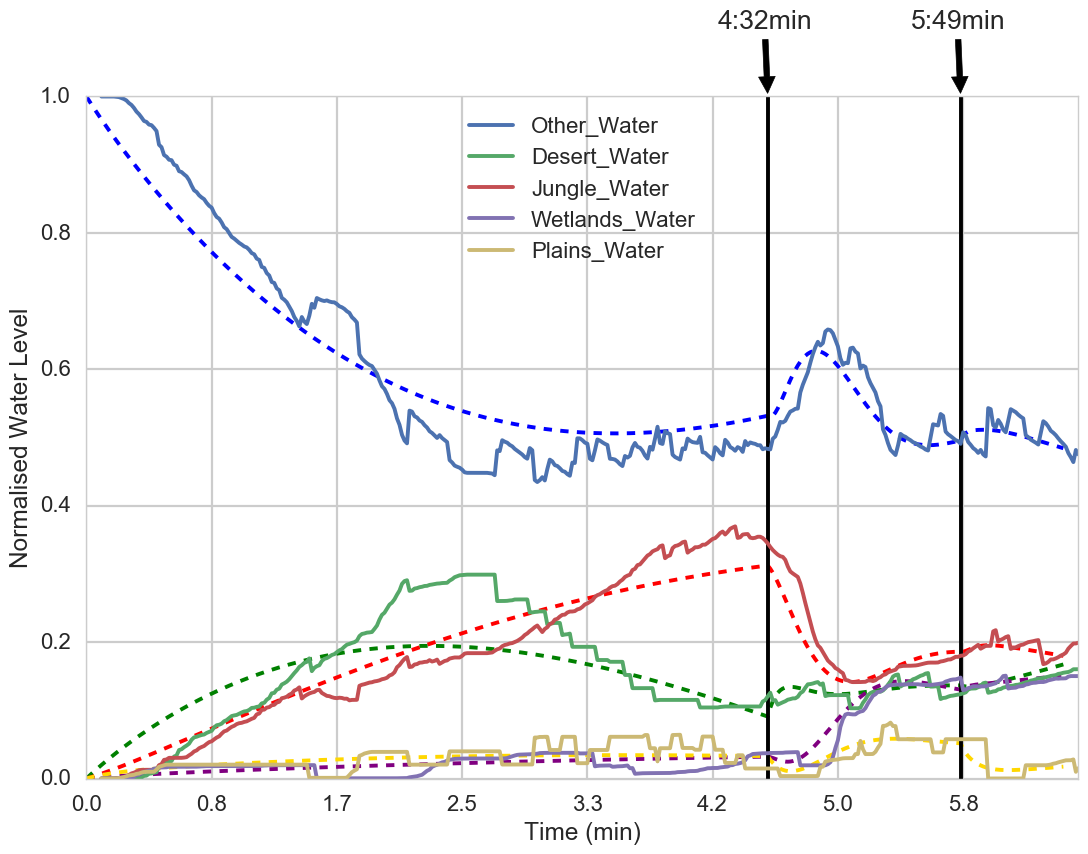

In [31]:
fig, ax = plt.subplots(1,1)
ax = cw_utils.plot_data_and_boundaries(df=data_csvs[df_name], em_results=em_res, ax=ax)
plt.show()

Split 4:32 min
Logs leading into Split


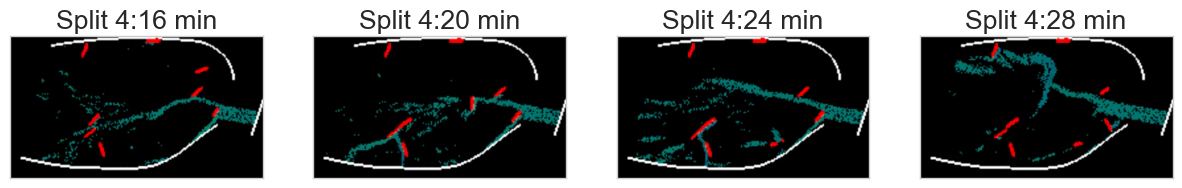

Logs after split


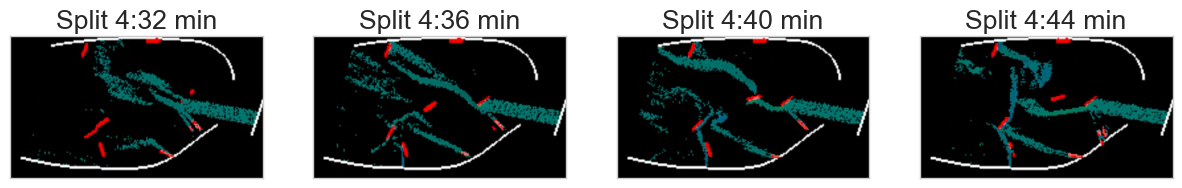

--------------------------------------------------------
--------------------------------------------------------

Split 5:49 min
Logs leading into Split


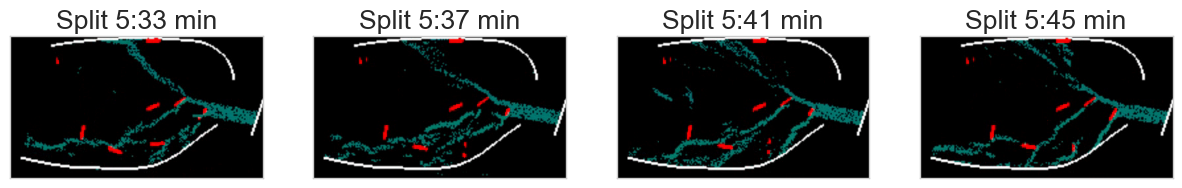

Logs after split


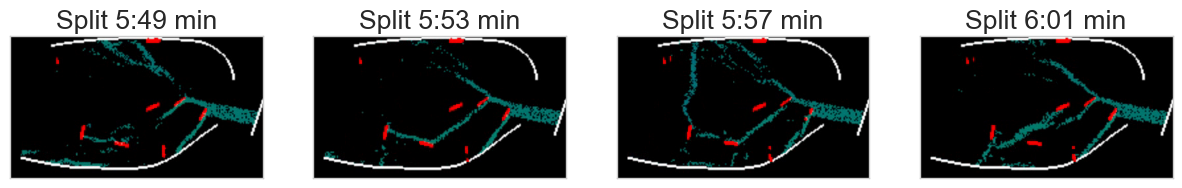

--------------------------------------------------------
--------------------------------------------------------



In [32]:
# for each split in found splits
video_name = names[int(df_name.split('_')[1])-1]
video_name = video_name.replace('.csv', '.mov')
for time_split in results[df_name]['breaks']:
    
    if time_split not in [0, len(data_csvs[df_name].values)]:
        
        min_ = time_split // 60
        sec_ = time_split - (min_ * 60)

        print("Split %i:%02d min" % (min_, sec_))
        print("Logs leading into Split")
        fig, axes = plt.subplots(1,4, figsize=(15,4))
        for i, ax in enumerate(axes):
            
            ts = time_split - (16-4*i)
            min_ = ts // 60
            sec_ = ts - (min_ * 60)
        
            ax.set_title("Split %i:%02d min" % (min_, sec_))
            
            cap = cv2.VideoCapture(path + video_name)
            cap.set(1,ts)
            ret, frame = cap.read()
            
            ax.set_aspect('equal')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    
            ax.imshow(frame[864:1080,0:384])
        plt.show()
        
        print("Logs after split")
        fig, axes = plt.subplots(1,4, figsize=(15,4))
        for i, ax in enumerate(axes):
            
            ts = time_split + 4*(i)
            min_ = ts // 60
            sec_ = ts - (min_ * 60)
        
            ax.set_title("Split %i:%02d min" % (min_, sec_))
            
            cap = cv2.VideoCapture(path + video_name)
            cap.set(1,ts)
            ret, frame = cap.read()
            
            ax.set_aspect('equal')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    
            ax.imshow(frame[864:1080,0:384])
        plt.show()
        
        print('--------------------------------------------------------')
        print('--------------------------------------------------------')
        print()

<hr />
### Test 5

In [33]:
df_name = 'df_5'

if df_name in results:
    em_res = results[df_name]
else:
    em_res = cw_utils.learn_breakpoint(data_csvs[df_name].values, num_breaks=6, starting_params=params, percentage=90)
    results[df_name] = em_res

[  0  66 132 198 264 330 397]
[  0  62 125 209 258 344 397]
[  0  58 122 211 254 349 397]
3
[  0  53 116 250 352 397]
[  0  47 114 252 352 397]
[  0  40 110 254 353 397]
[  0  38 106 255 353 397]
[  0  37  98 259 354 397]
[  0  35  93 264 354 397]
[  0  30  93 261 354 397]
0
[ 27  95 264 355 397]
[  0  93 259 354 397]
[  0  97 263 355 397]
[  0  97 260 354 397]
[  0  97 264 355 397]
Converged


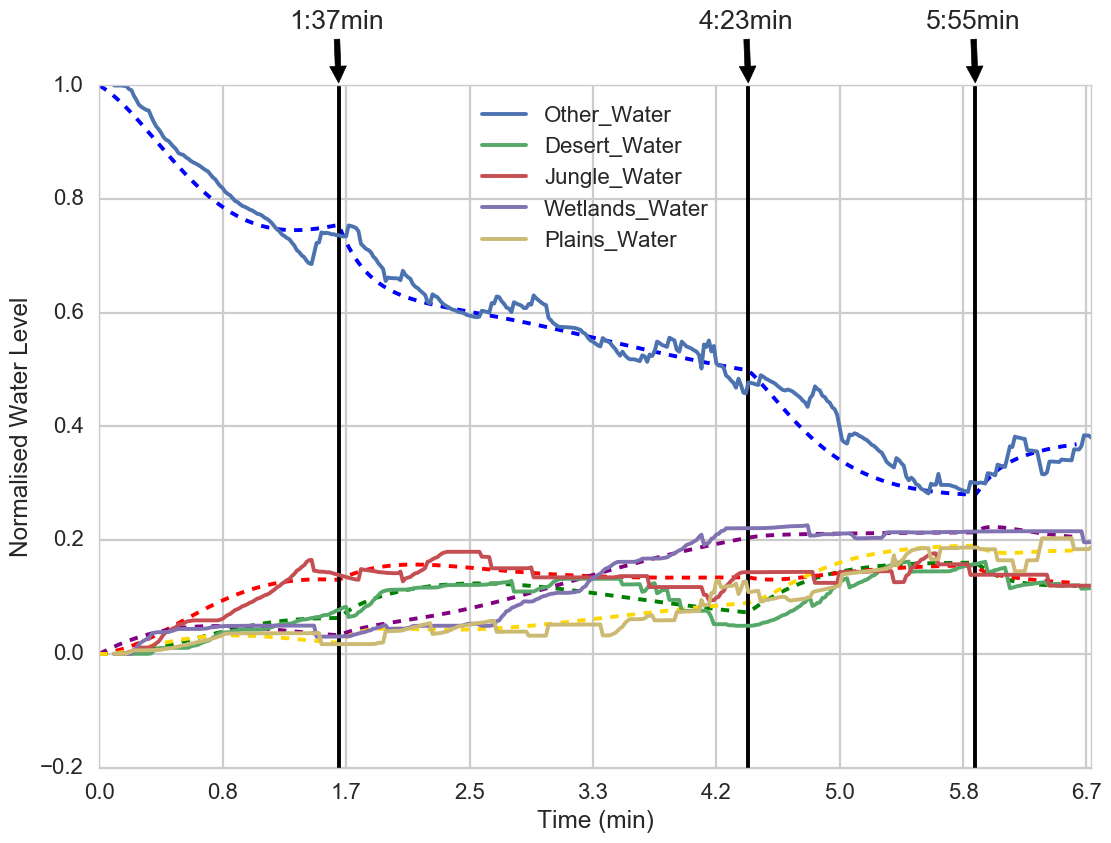

In [34]:
fig, ax = plt.subplots(1,1)
ax = cw_utils.plot_data_and_boundaries(df=data_csvs[df_name], em_results=em_res, ax=ax)
plt.show()

Split 1:37 min
Logs leading into Split


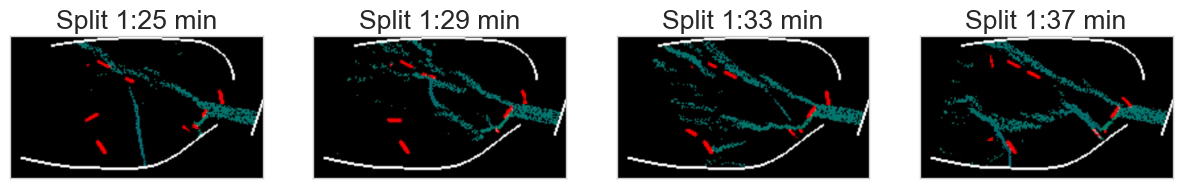

Logs after split


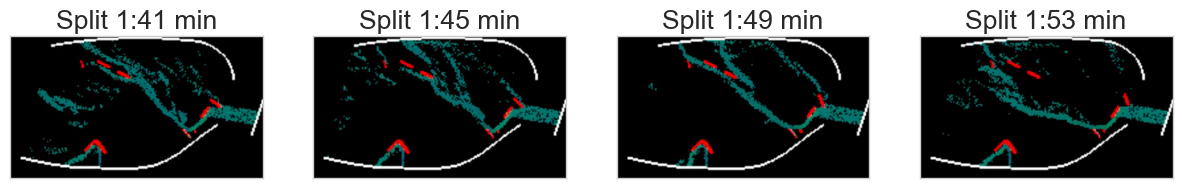

--------------------------------------------------------
--------------------------------------------------------

Split 4:23 min
Logs leading into Split


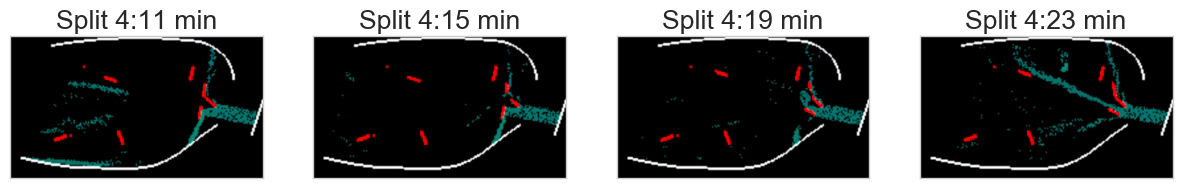

Logs after split


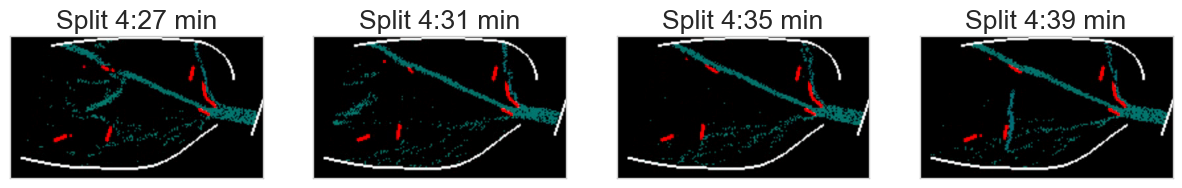

--------------------------------------------------------
--------------------------------------------------------

Split 5:55 min
Logs leading into Split


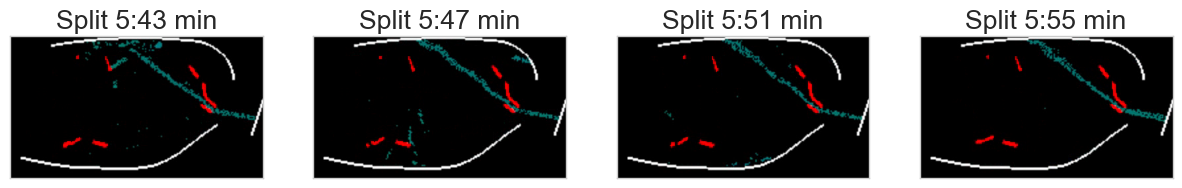

Logs after split


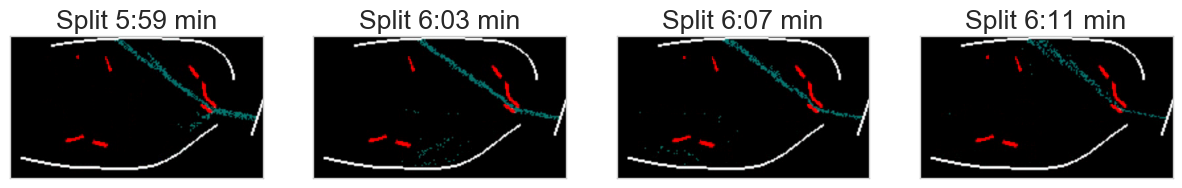

--------------------------------------------------------
--------------------------------------------------------



In [35]:
# for each split in found splits
video_name = names[int(df_name.split('_')[1])-1]
video_name = video_name.replace('.csv', '.mov')
for time_split in results[df_name]['breaks']:
    
    if time_split not in [0, len(data_csvs[df_name].values)]:
        
        min_ = time_split // 60
        sec_ = time_split - (min_ * 60)

        print("Split %i:%02d min" % (min_, sec_))
        print("Logs leading into Split")
        fig, axes = plt.subplots(1,4, figsize=(15,4))
        for i, ax in enumerate(axes):
            
            ts = time_split - (12-4*i)
            min_ = ts // 60
            sec_ = ts - (min_ * 60)
        
            ax.set_title("Split %i:%02d min" % (min_, sec_))
            
            cap = cv2.VideoCapture(path + video_name)
            cap.set(1,ts)
            ret, frame = cap.read()
            
            ax.set_aspect('equal')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    
            ax.imshow(frame[864:1080,0:384])
        plt.show()
        
        print("Logs after split")
        fig, axes = plt.subplots(1,4, figsize=(15,4))
        for i, ax in enumerate(axes):
            
            ts = time_split + 4*(i+1)
            min_ = ts // 60
            sec_ = ts - (min_ * 60)
        
            ax.set_title("Split %i:%02d min" % (min_, sec_))
            
            cap = cv2.VideoCapture(path + video_name)
            cap.set(1,ts)
            ret, frame = cap.read()
            
            ax.set_aspect('equal')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    
            ax.imshow(frame[864:1080,0:384])
        plt.show()
        
        print('--------------------------------------------------------')
        print('--------------------------------------------------------')
        print()